In [1]:
# load necessary libraries

library('tidyverse')
library('ggthemes')
library('multcomp')


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




In [ ]:
# all male animals
# animals were first tested in a tail flick for two days in a row (days -2 and -1)
# then starting day 0 treated with Drug A or Drug C plus Drug B or drug D days 0 - 4. 
# On days 5 and 6, animals recieved drugs in the morning

# finally, on day 8, animals start social interaction test
# the test involves placing the test animal in a two-sidered chamber and allowing the animal to explore for 10
# minutes. Then a new animal is placed in a cage at one side of the chamber. Times spent interacting on the 
# 'social' side vs on the 'empty' side are recorded and compared

# 'Hours' column refers to time since last drug A or C dose
# 'Distance' column refers to distance traveled during trial in cm, 'Velocity' is cm/sec
# 'EmptySocial' is the number of transfers from the empty side of the chamber to the social side
# 'SocialEmpty' is the number of transfers from the social side to the empty side

# Note that this data is for ONLY the social interaction test

# first we read in the data

behavior <- read.csv('soc_csv_blog.csv')

# convert all NA to NaN
is.nan.data.frame <- function(x)
  do.call(cbind, lapply(x, is.na))

behavior[is.na(behavior)] <- NaN

# get first six rows and all columns
head(behavior)

In [152]:
# add percent immobile column to data frame
behavior['PercentImmobile'] <- 100*(behavior['Immobile']/(behavior['Immobile'] + behavior['Mobile']))


In [74]:
# Define a function that gives count, mean, standard deviation, standard error of the mean, 
# and confidence interval (default is 95% CI):
#   data: a data frame.
#   measurevar: the name of a column that contains the variable to be summariezed
#   groupvars: a vector containing names of columns that contain grouping variables
#   na.rm: a boolean that indicates whether to ignore NA's
#   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=FALSE) {

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    stdev <- function(x, na.rm=TRUE) {
        var2 = 0
        for (i in x) {
            val <- (i - mean(x))^2
            var2 + val
            }
        return(sqrt(val/mean(x)))
    }
    
    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = stdev  (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

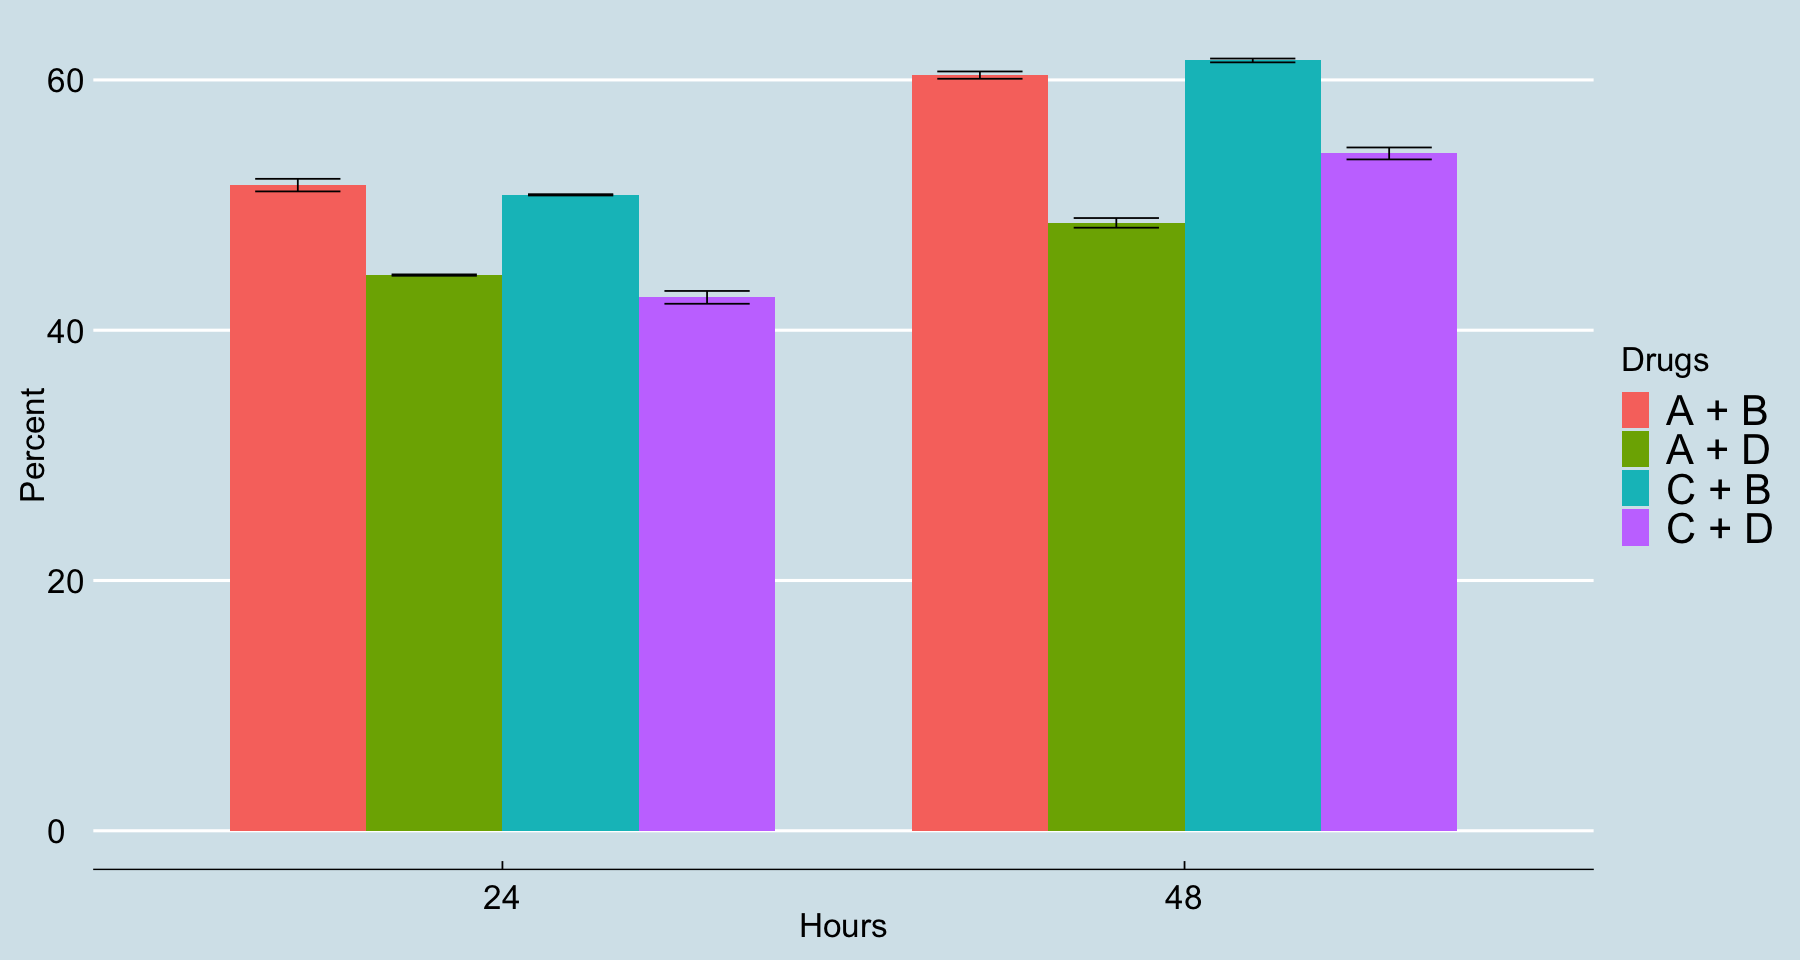

In [100]:
# plot PercentImmobile for both hours conditions
# note that we use ci = 69 to get error bars with +/- SEM

behav2 <- summarySE(behavior, measurevar="PercentImmobile", groupvars=c("Hours", "Drugs"), na.rm = TRUE,
                   conf.interval = 0.68)

# change the Hours column to a factor for plotting
behav2$Hours <- factor(behav2$Hours)

# make the plot
p <- ggplot(behav2, aes(x=Hours, y=PercentImmobile, fill=Drugs, ymin=PercentImmobile-ci, ymax=PercentImmobile+ci)) +
    geom_bar(stat = "identity", position = "dodge", width = 0.8) +
    geom_errorbar(width = 0.5, position = position_dodge(0.8))

# change the size of text, the y-axis label, and the position of the legend
p + theme_economist() + theme(text = element_text(size=20)) + ylab("Percent") + theme(legend.position = "right")

# to save the plot uncomment the following
# ggsave('fig1_R.png', device = 'png', height = 8 , width = 8, dpi = 200)

In [174]:
# We first split the Drugs column to get Drug1 and Drug2 conditions
behav3 <- behavior %>%
  separate(Drugs, c('Drug1', 'Drug2'), remove = FALSE, sep = '[+]', extra = 'drop')

# Run two-way anova to determine if PercentImmobile depends on Drugs
res.aov2 <- aov(PercentImmobile ~ Hours * Drug1 * Drug2, data = na.omit(behav3))
summary(res.aov2)

                  Df Sum Sq Mean Sq F value   Pr(>F)    
Hours              1   1337  1336.9  22.239 1.48e-05 ***
Drug1              1      2     1.9   0.031    0.861    
Drug2              1   1187  1187.3  19.750 3.87e-05 ***
Hours:Drug1        1    108   108.2   1.799    0.185    
Hours:Drug2        1     14    14.4   0.240    0.626    
Drug1:Drug2        1     11    11.3   0.188    0.666    
Hours:Drug1:Drug2  1     29    28.7   0.478    0.492    
Residuals         60   3607    60.1                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [246]:
# Tukey's honest significance test

# because we have a within-subjects experimental design (2 time points)
# we have to add a column for keeping track of the interaction effects

behav3$HoursDrugs <- interaction(behav3$Hours, behav3$Drugs)

results <- TukeyHSD(aov(PercentImmobile ~ HoursDrugs, data = behav3))

# printing results will give you all the p-values
# if you only want them below a certain threshold

res <- as.data.frame(results$HoursDrugs)
res[res$`p adj` < 0.05, ]

,diff,lwr,upr,p adj
,<dbl>,<dbl>,<dbl>,<dbl>
24.A + D-48.A + B,-15.97925,-28.2496648,-3.708832,0.0031016881
24.C + D-48.A + B,-17.75967,-29.3396177,-6.179714,0.0002641961
48.C + B-24.A + D,17.15057,4.3178590,29.983277,0.0021873688
48.C + B-48.A + D,12.97867,0.1459644,25.811382,0.0455687015
24.C + D-48.C + B,-18.93099,-31.1051622,-6.756809,0.0002082777
48.C + D-24.C + D,11.49977,1.5595962,21.439943,0.0127330382
